# Mutliple multiplications, multiple layers

I'd like to look into orthogonality in hidden weight matrices.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 689334534
set_all_seeds(seed)
print(seed)

3108401495


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


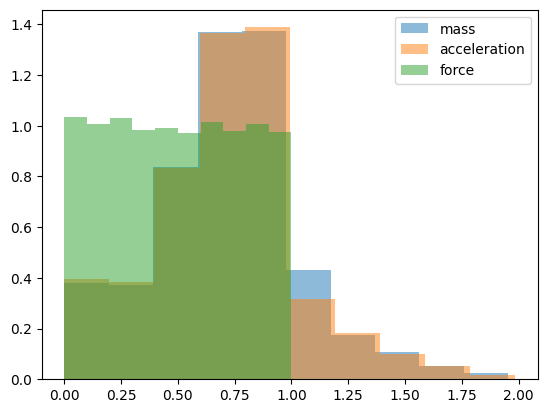

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

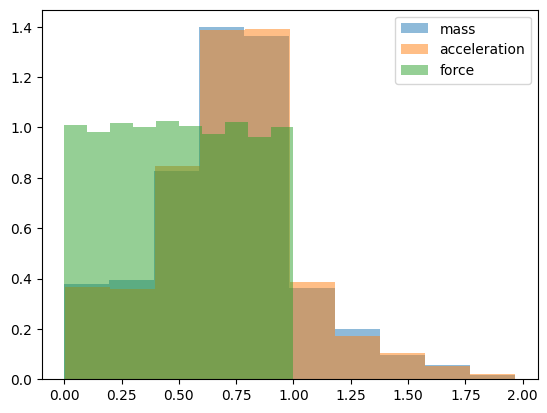

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 4000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

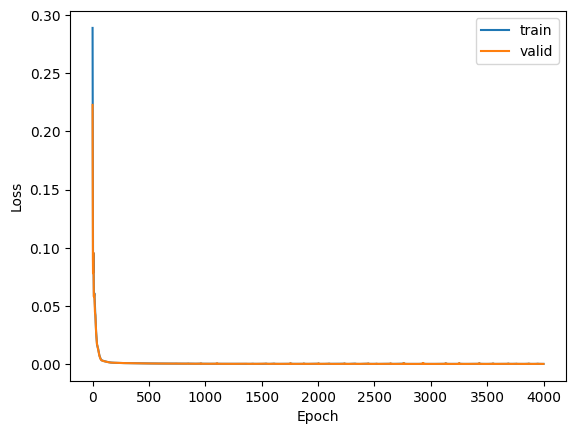

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(6.0303e-05)

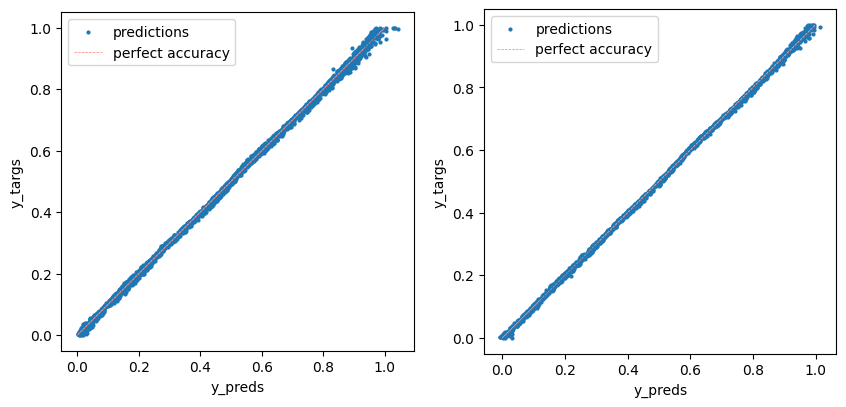

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

I would like to look at the weight matrix of the second linear layer.

In [15]:
W = model.state_dict()["layers.1.linear.weight"]
W.shape

torch.Size([16, 16])

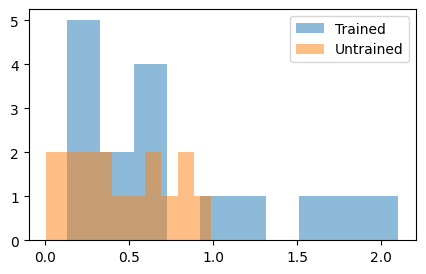

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.hist(torch.svd(W).S.detach().numpy(), alpha=0.5, label="Trained")
ax.hist(
    torch.svd(Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2).state_dict()["layers.1.linear.weight"])
    .S.detach()
    .numpy(),
    alpha=0.5,
    label="Untrained",
)

_ = ax.legend()

In [17]:
torch.svd(W).S

tensor([2.1045, 1.7735, 1.6403, 1.3119, 0.9273, 0.7157, 0.6992, 0.6830, 0.5997,
        0.5129, 0.3982, 0.2877, 0.2464, 0.1701, 0.1593, 0.1315])

Some observations:
- I've played around with a few hidden dimension values here and, as one might expect, the number of high singular values (which I'm defining as higher than the distribution of the untrained W matrices i.e. > 1) as a proportion of all of the values decreases as we add more capacity (width). The intuition behind this being that the network does not "need" so many orthogonal dimensions to achieve this task so can afford to have a large number of non-orthogonal operations. 
- I'm not sure if these higher singular values necessarily signify "important" directions in the space because I'd imagine the next layer could "undo" importance weighting in this one. There would need to be a more holistic analysis to understand this Q.
- People look at SVD decompositions all the time so this is probably not all that original but it's still useful for me to understand.

I'm interested in getting a sense of how orthogonal the weight matrix columns are from each other in the neuron basis.

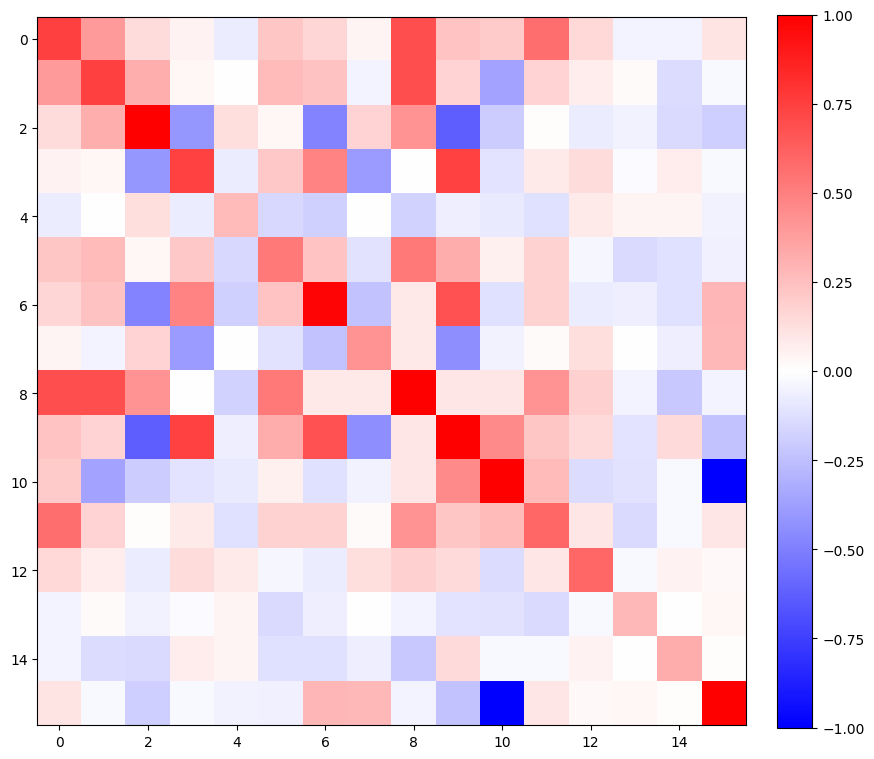

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(torch.matmul(W, W.T).numpy(), cmap="bwr", vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

Generally doesn't seem like there's much in the way of orthogonality in the neuron basis so all the action in terms of independent operations is happening in the rotated basis.

I'm starting to get a better intuition of why this is: how can you really do any interesting computation (e.g. partitioning off various parts of a non-uniform input space) without rotating your intermediate "features" with respect to the non-linearities? 

I kind of see this intuitively as a carpenter angling their piece of wood against a sand belt - they're only going to be able to transform the wood and create interesting shapes if they orientate it in "unusual" bases with respect to the neutral basis of the sand belt. That is, unless their sand belt's basis is already arranged in the correct orientation - but this means the sand belt is less neutral/flexible for various tasks (this would be like a CNC mill) OR the original inputted piece of wood is already in the basis of interest (but this would mean you're starting with the finished product and therefore don't need to do any work) 🪚

### Where does this leave us?

Ok so the presence of some independent operations in the SVD decomposed space is useful. Some questions to think about now:
- do these exist in single-task networks? I'd expect them maybe not to, unless there are independent sub-tasks of the single task that are useful to compute.
- can we now use these singular values to understand channels of independent computation through the network? Can one create chains from them?
- do the activations associated with the components with smaller singular values act to cancel each other out?